# Решение задания в Samokat.tech


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import get_scheduler
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip install pymorphy2
!pip install datasets

In [14]:
import pandas as pd
train_data = pd.read_csv('/content/train_dataset.csv')
test_data = pd.read_csv('/content/test_dataset.csv')

In [ ]:
full_data = pd.concat([train_data,test_data],axis = 0)

In [23]:
full_data

,text,label
0,the rock'n'roll is designate to be the 21st ce...,1
1,"the gorgeously elaborated continuation of "" th...",1
2,effective merely too - tepid biopic,1
3,if you sometimes same to go to the moving pict...,1
4,"emerges as something rare, an issue movie that...",1
...,...,...
1061,a terrible movie that some people will neverth...,0
1062,there are many definitions of 'time waster' bu...,0
1063,"as it stands , crocodile hunter has the hurrie...",0
1064,the thing looks like a made-for-home-video qui...,0


Так как сбалансированные классы, то я выбрал accuracy и f1_score

<Axes: xlabel='label', ylabel='Count'>

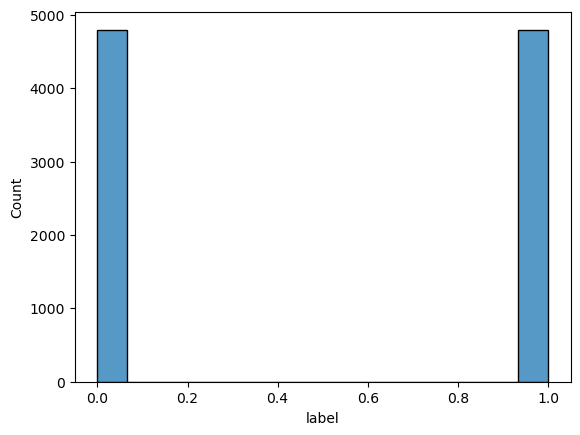

In [ ]:
import seaborn as sns
sns.histplot(full_data['label'])

In [ ]:
import nltk
import pymorphy2
import string
from nltk.corpus import stopwords
import re
from tqdm import tqdm_notebook
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize,sent_tokenize
sent_pol = []
sent_otr = []

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

sent_ham = []
for sentence in tqdm_notebook(full_data[full_data['label'] == 0]['text']):
    cleaned_sentence = remove_punctuation(sentence)
    sent_pol.extend(
        [x.lower() for x in word_tokenize(re.sub(r'[0-9]+', '', cleaned_sentence.lower()), language='english') if x not in set(stopwords.words('english'))]
    )

for sentence in tqdm_notebook(full_data[full_data['label'] == 1]['text']):
  cleaned_sentence = remove_punctuation(sentence)
  sent_otr.extend(
      [x.lower() for x in word_tokenize(re.sub(r'[0-9]+', '', cleaned_sentence.lower()),language = 'english') if x.lower() not in set(stopwords.words('english'))]
  )

from collections import Counter
chars_pol = Counter()
chars_otr = Counter()

for sentence in tqdm_notebook(sent_pol):
    chars_pol[sentence] += 1

for sentence in tqdm_notebook(sent_otr):
    chars_otr[sentence] += 1

<BarContainer object of 20 artists>

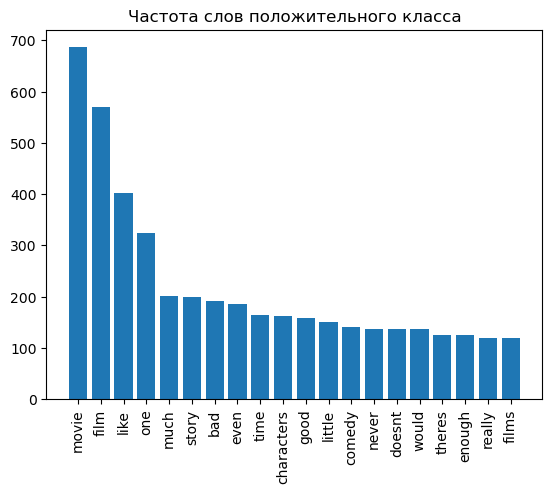

In [ ]:
import matplotlib.pyplot as plt
plt.title('Частота слов положительного класса')
co_ham = pd.DataFrame(index = ['word','count'],data = [chars_pol.keys(),chars_pol.values()]).T.sort_values('count',ascending = False)[:20]

plt.xticks(rotation = 90)
plt.bar(co_ham['word'],co_ham['count'])

<BarContainer object of 20 artists>

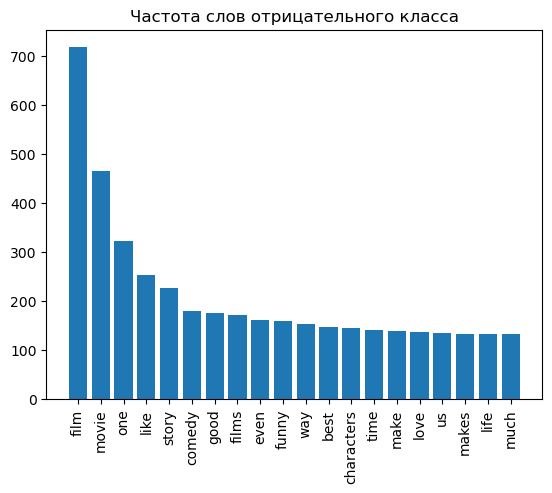

In [ ]:
import matplotlib.pyplot as plt
plt.title('Частота слов отрицательного класса')
co_ham = pd.DataFrame(index = ['word','count'],data = [chars_otr.keys(),chars_otr.values()]).T.sort_values('count',ascending = False)[:20]

plt.xticks(rotation = 90)
plt.bar(co_ham['word'],co_ham['count'])

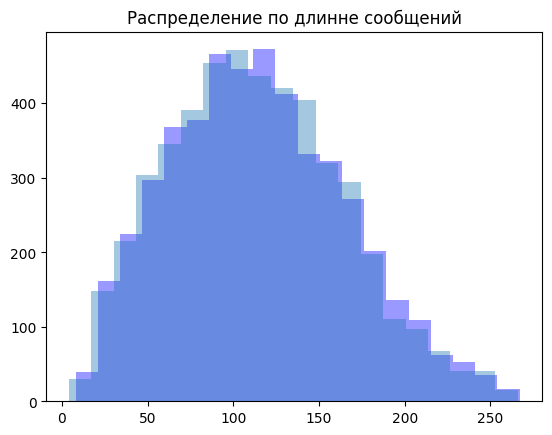

In [ ]:
import matplotlib.pyplot as plt
plt.title('Распределение по длинне сообщений')
plt.hist(full_data[full_data['label'] == 1]['text'].apply(lambda x: len(x)),bins = 20,color = 'b',alpha = 0.4);
plt.hist(full_data[full_data['label'] == 0]['text'].apply(lambda x: len(x)),alpha = 0.4,bins = 20);

In [9]:
import torch
import string
from nltk.corpus import stopwords
import nltk
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from transformers import BertTokenizer,BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
embedder_bert = BertModel.from_pretrained('bert-base-cased').to(device)
embedder_bert.pooler = nn.Identity()
del embedder_bert.encoder.layer[:]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
train_tokens = tokenizer(list(train_data['text']), padding = True, truncation=True)
test_tokens = tokenizer(list(test_data['text']), padding = True, truncation=True)

In [ ]:
from torch.utils.data import Dataset,DataLoader
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = train_data['text']
            self.tokens = train_tokens
            self.labels = list(train_data['label'])
        else:
            self.text_data = test_data['text']
            self.tokens = test_tokens
            self.labels = list(test_data['label'])

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['label'] = torch.tensor(self.labels[idx])
        return sample

In [ ]:
class BERTModel(nn.Module):
    def __init__(self,num_classes):
        super(BERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.fc = nn.Linear(768, 300)
        self.fc1 = nn.Linear(300,100)
        self.fc2 = nn.Linear(100,num_classes)

        self.tanh = nn.Tanh()
        self.drop = nn.Dropout(p = 0.7)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        x = self.tanh(self.fc(pooled_output))
        x = self.drop(x)
        x = self.tanh(self.fc1(x))
        x = self.drop(x)
        logits = self.tanh(self.fc2(x))
        return logits


In [ ]:
batch_size = 32
train_dataset = TokenData(train = True)
train_dataloader = DataLoader(train_dataset,shuffle = True,batch_size = 32)

test_dataset = TokenData(train = False)
test_dataloader = DataLoader(test_dataset,shuffle = True,batch_size = batch_size)

# Обучене без Mixup


In [ ]:
import numpy as np
import torch.optim as optim
import torch.nn as nn
from transformers import BertForSequenceClassification
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score

def get_perm(x):
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    return index

def mixup_criterion_cross_entropy(pred, y_a, y_b, lam):
    return lam * loss_fn(pred,y_a) + (1 - lam) * loss_fn(pred,y_b)

def mixup_data(x1, x2, lam):
    mixed_x = lam * x1 + (1 - lam) * x2
    return mixed_x

bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased')
#bert_model = BERTModel(num_classes = 2)
optimizer = optim.AdamW(bert_model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
bert_model.to(device)

for epoch in range(num_epochs):
    print("Epoch: ",(epoch + 1))
    bert_model.train()
    correct = 0
    total = 0
    for i,batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        outputs = bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])

        pred = outputs.logits
        loss = loss_fn(pred, batch['label'])

        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_last_loss = train_batch_loss / batch_size


        print('Training batch {} last loss: {}'.format(i + 1, train_last_loss))

    print(f"\nTraining epoch {epoch + 1} loss: ",train_last_loss)


    bert_model.eval()
    correct = 0
    test_pred = []
    for i, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])

        logits = outputs.logits

        loss = loss_fn(logits, batch['label'])
        test_batch_loss = loss.item()

        test_last_loss = test_batch_loss / batch_size
        print('Testing batch {} loss: {}'.format(i + 1, test_last_loss))

        correct += (logits.argmax(1) == batch['label']).sum().item()
        print("Testing accuracy: ",correct/((i + 1) * batch_size),'Testing f1_score:',f1_score(batch['label'].cpu(),logits.argmax(1).cpu(),average = 'weighted'))

    print(f"\nTesting epoch {epoch + 1} last loss: ",test_last_loss)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:  1
Training batch 1 last loss: 0.02296130545437336
Training batch 2 last loss: 0.022783732041716576
Training batch 3 last loss: 0.022039314731955528
Training batch 4 last loss: 0.023052316159009933
Training batch 5 last loss: 0.022167449817061424
Training batch 6 last loss: 0.02227010391652584
Training batch 7 last loss: 0.022433146834373474
Training batch 8 last loss: 0.0212372075766325
Training batch 9 last loss: 0.02123362571001053
Training batch 10 last loss: 0.020195262506604195
Training batch 11 last loss: 0.022222666069865227
Training batch 12 last loss: 0.02210843749344349
Training batch 13 last loss: 0.021670516580343246
Training batch 14 last loss: 0.020711923018097878
Training batch 15 last loss: 0.023121509701013565
Training batch 16 last loss: 0.021002113819122314
Training batch 17 last loss: 0.020989231765270233
Training batch 18 last loss: 0.021658986806869507
Training batch 19 last loss: 0.022263869643211365
Training batch 20 last loss: 0.02158547192811966
Traini

# Обучение с Mixup (на CPU)

Если без mixup не было проблем, то с ним уже возникли, так как модель не сходилась, что бы то я не делал:

Я написал архитектуру через BertModel и игрался с Dropout, линейными преобразованиями, менял парамтеры внутри BertForSequenceClassification, но ничего не вышло

Тут я написал кастомную функцию потерь + саму функцию mixup

Возможно тут лучше бы помогло обучать на GPU, так как все же асинхронное обучение + попробовать WordEmbsAug с glove или обратным переводом

**Также я не применял mixup к таргктам, так как данная задача этого не предполагает**

In [ ]:
def mixup_criterion_cross_entropy(loss_fn,pred, y_a, y_b, lam):
    return lam * loss_fn(pred,y_a) + (1 - lam) * loss_fn(pred,y_b)

In [ ]:
import numpy as np
import torch.optim as optim
import torch.nn as nn
from transformers import BertForSequenceClassification
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score

def get_perm(x):
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    return index

def mixup_data(x1, x2, lam):
    mixed_x = lam * x1 + (1 - lam) * x2
    return mixed_x

bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased')
#bert_model = BERTModel(num_classes = 2)
optimizer = optim.AdamW(bert_model.parameters(), lr = 0.000001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
bert_model.to(device)

for epoch in range(num_epochs):
    print("Epoch: ",(epoch + 1))
    bert_model.train()
    correct = 0
    total = 0
    for i,batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        lam = np.random.beta(1,1)

        index = get_perm(batch['input_ids'])
        x1 = batch['input_ids'][index].to(device)
        y1 = batch['label'][index].to(device)
        att1 = batch['attention_mask'][index].to(device)

        mixed_x = mixup_data(batch['input_ids'].to(device),x1.to(device),lam)
        mixed_att = mixup_data(batch['attention_mask'].to(device),att1.to(device),lam)

        pred = bert_model(input_ids = mixed_x.to(torch.int32), attention_mask = mixed_att.to(torch.int32))

        pred = pred.logits
        loss = mixup_criterion_cross_entropy(loss_fn,pred,batch['label'],y1,lam)
        #loss = loss_fn(pred,batch['label'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Training batch {} last loss: {}'.format(i + 1, loss.item() / batch_size))

    print(f"\nTraining epoch {epoch + 1} loss: ",loss)


    bert_model.eval()
    correct = 0
    test_pred = []
    for i, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            logits = bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])

        logits = logits.logits
        loss = loss_fn(logits, batch['label'])
        test_batch_loss = loss.item()

        test_last_loss = test_batch_loss / batch_size
        print('Testing batch {} loss: {}'.format(i + 1, test_last_loss))

        correct += (logits.argmax(1) == batch['label']).sum().item()
        print("Testing accuracy: ",correct/((i + 1) * batch_size),'Testing f1_score:',f1_score(batch['label'].cpu(),logits.argmax(1).cpu(),average = 'weighted'))

    print(f"\nTesting epoch {epoch + 1} last loss: ",test_last_loss)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:  1
Training batch 1 last loss: 0.025937382131814957
Training batch 2 last loss: 0.031101690605282784
Training batch 3 last loss: 0.028734369203448296
Training batch 4 last loss: 0.024807361885905266
Training batch 5 last loss: 0.031133074313402176
Training batch 6 last loss: 0.023121709004044533
Training batch 7 last loss: 0.025375928729772568
Training batch 8 last loss: 0.02633795328438282
Training batch 9 last loss: 0.026325011625885963
Training batch 10 last loss: 0.023882931098341942
Training batch 11 last loss: 0.02248181775212288
Training batch 12 last loss: 0.025551211088895798
Training batch 13 last loss: 0.024213727563619614
Training batch 14 last loss: 0.02692117542028427
Training batch 15 last loss: 0.02400386892259121
Training batch 16 last loss: 0.02223842591047287
Training batch 17 last loss: 0.0216676015406847
Training batch 18 last loss: 0.022865954786539078
Training batch 19 last loss: 0.021584773436188698
Training batch 20 last loss: 0.026137875393033028
Traini

# Обучение с Mixup и Trainer

Я понял, что без GPU я не смогу добиться хорошей сходимости модели и поэтому я решил попробовать реализовать mixup, но без кастомной функции ошибок и через TrainingArguments, так как будто никак иначе

In [ ]:
batch_size = 32
train_dataset = TokenData(train = True)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)

test_dataset = TokenData(train = False)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size = batch_size)

In [ ]:
import numpy as np

input_ids = []
attention = []
label = []

def get_perm(x):
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    return index

def mixup_data(x1, x2, lam):
    mixed_x = lam * x1 + (1 - lam) * x2
    return mixed_x

def mixup_criterion_cross_entropy(loss_fn,pred, y_a, y_b, lam):
    return lam * loss_fn(pred,y_a) + (1 - lam) * loss_fn(pred,y_b)

for i,batch in enumerate(train_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}

    lam = np.random.beta(1,1)

    index = get_perm(batch['input_ids'])
    x1 = batch['input_ids'][index].to(device)
    y1 = batch['label'][index].to(device)
    att1 = batch['attention_mask'][index].to(device)

    mixed_x = mixup_data(batch['input_ids'].to(device),x1.to(device),lam)
    mixed_att = mixup_data(batch['attention_mask'].to(device),att1.to(device),lam)

    input_ids.append(mixed_x.to(torch.int32).tolist())
    attention.append(mixed_att.to(torch.int32).tolist())
    label.append(int(batch['label'][0]))

In [ ]:
input = pd.DataFrame(input_ids,columns = ['input_ids'])
attention_mask = pd.DataFrame(attention,columns = ['attention_mask'])
lab  = pd.DataFrame(label,columns = ['label'])

In [ ]:
train_tokens = pd.concat([input,attention_mask,lab],axis = 1)

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(
    pd.DataFrame({"input_ids": train_tokens['input_ids'], "attention_mask": train_tokens['attention_mask'],'label':train_tokens['label']})
)
val_dataset = Dataset.from_pandas(
    pd.DataFrame({"text": val_data['text'], "label": val_data['label']})
)

def tokenize(batch):
    return tokenizer(batch["text"],padding = "max_length",truncation = True,max_length = 128)

val_dataset = val_dataset.map(tokenize, batched = True)

train_dataset.set_format("torch", columns = ["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns = ["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import BertForSequenceClassification,TrainingArguments,Trainer
from sklearn.metrics import roc_auc_score,f1_score

model = bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased')

training_args = TrainingArguments(
    num_train_epochs = 5,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    warmup_steps = 500,
    weight_decay = 0.05,
    output_dir = './noth'
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    compute_metrics = lambda pred: {
        "f1": f1_score(val_dataset['label'],pred.predictions.argmax(1))
    }
)

trainer.train()
print("f1_score:", trainer.evaluate()["eval_f1"])

/Users/admin/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/admin/anaconda3/lib/python3.11/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Step,Training Loss
500,0.421300
1000,0.143700


f1_score: 0.8592592592592593


#Аугаментация через синонимы

Скажу так, что по мне задача аугаментации на этом датасете может быть полезна для обычного разнообразия слов на тесте, для расширения обучения + это добавляет обобщения.

Поэтому я решил, что можно поробовать не аугаментацию не через эмбеддинги, которые можно реализовать через word2vec или fasttext через способ naw.WordEmbsAug, а через обычную замену через синонимы, которые, впринципе, неплохо справляются с аугаментацией.

In [3]:
!pip install --upgrade gensim --quiet

In [ ]:
import gensim
gensim.__version__

'4.3.2'

In [ ]:
!pip install nlpaug

In [6]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action

In [15]:
aug = naw.SynonymAug(aug_src = 'wordnet',aug_max = 20)

def augement(text):
  return aug.augment(text)

train_data['text'] = train_data['text'].apply(lambda x: augement(x)[0])

In [16]:
full_data = pd.concat([train_data,test_data],axis = 0)

In [17]:
import nltk
import pymorphy2
import string
from nltk.corpus import stopwords
import re
from tqdm import tqdm_notebook
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import word_tokenize,sent_tokenize
sent_pol = []
sent_otr = []

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

sent_ham = []
for sentence in tqdm_notebook(full_data[full_data['label'] == 0]['text']):
    cleaned_sentence = remove_punctuation(sentence)
    sent_pol.extend(
        [x.lower() for x in word_tokenize(re.sub(r'[0-9]+', '', cleaned_sentence.lower()), language='english') if x not in set(stopwords.words('english'))]
    )

for sentence in tqdm_notebook(full_data[full_data['label'] == 1]['text']):
  cleaned_sentence = remove_punctuation(sentence)
  sent_otr.extend(
      [x.lower() for x in word_tokenize(re.sub(r'[0-9]+', '', cleaned_sentence.lower()),language = 'english') if x.lower() not in set(stopwords.words('english'))]
  )

from collections import Counter
chars_pol = Counter()
chars_otr = Counter()

for sentence in tqdm_notebook(sent_pol):
    chars_pol[sentence] += 1

for sentence in tqdm_notebook(sent_otr):
    chars_otr[sentence] += 1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-17-f35211d85c3e>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(full_data[full_data['label'] == 0]['text']):


  0%|          | 0/4798 [00:00<?, ?it/s]

<ipython-input-17-f35211d85c3e>:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(full_data[full_data['label'] == 1]['text']):


  0%|          | 0/4798 [00:00<?, ?it/s]

<ipython-input-17-f35211d85c3e>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(sent_pol):


  0%|          | 0/58603 [00:00<?, ?it/s]

<ipython-input-17-f35211d85c3e>:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentence in tqdm_notebook(sent_otr):


  0%|          | 0/58781 [00:00<?, ?it/s]

<BarContainer object of 20 artists>

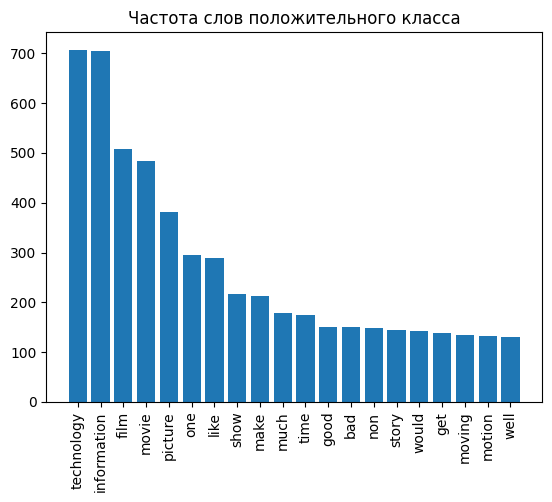

In [18]:
import matplotlib.pyplot as plt
plt.title('Частота слов положительного класса')
co_ham = pd.DataFrame(index = ['word','count'],data = [chars_pol.keys(),chars_pol.values()]).T.sort_values('count',ascending = False)[:20]

plt.xticks(rotation = 90)
plt.bar(co_ham['word'],co_ham['count'])

<BarContainer object of 20 artists>

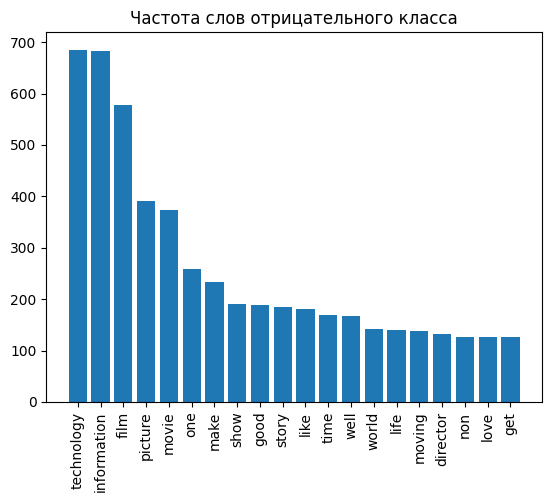

In [19]:
import matplotlib.pyplot as plt
plt.title('Частота слов отрицательного класса')
co_ham = pd.DataFrame(index = ['word','count'],data = [chars_otr.keys(),chars_otr.values()]).T.sort_values('count',ascending = False)[:20]

plt.xticks(rotation = 90)
plt.bar(co_ham['word'],co_ham['count'])

In [10]:
train_tokens = tokenizer(list(train_data['text']), padding = True, truncation=True)
test_tokens = tokenizer(list(test_data['text']), padding = True, truncation=True)

In [11]:
from torch.utils.data import Dataset,DataLoader
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = train_data['text']
            self.tokens = train_tokens
            self.labels = list(train_data['label'])
        else:
            self.text_data = test_data['text']
            self.tokens = test_tokens
            self.labels = list(test_data['label'])

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['label'] = torch.tensor(self.labels[idx])
        return sample

In [12]:
batch_size = 32
train_dataset = TokenData(train = True)
train_dataloader = DataLoader(train_dataset,shuffle = True,batch_size = 32)

test_dataset = TokenData(train = False)
test_dataloader = DataLoader(test_dataset,shuffle = True,batch_size = batch_size)

In [20]:
import numpy as np
import torch.optim as optim
import torch.nn as nn
from transformers import BertForSequenceClassification
from tqdm import tqdm_notebook
from sklearn.metrics import f1_score

def get_perm(x):
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    return index

def mixup_criterion_cross_entropy(pred, y_a, y_b, lam):
    return lam * loss_fn(pred,y_a) + (1 - lam) * loss_fn(pred,y_b)

def mixup_data(x1, x2, lam):
    mixed_x = lam * x1 + (1 - lam) * x2
    return mixed_x

bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased')
#bert_model = BERTModel(num_classes = 2)
optimizer = optim.AdamW(bert_model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
bert_model.to(device)

for epoch in range(num_epochs):
    print("Epoch: ",(epoch + 1))
    bert_model.train()
    correct = 0
    total = 0
    for i,batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        outputs = bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])

        pred = outputs.logits
        loss = loss_fn(pred, batch['label'])

        loss.backward()
        optimizer.step()

        train_batch_loss = loss.item()
        train_last_loss = train_batch_loss / batch_size


        print('Training batch {} last loss: {}'.format(i + 1, train_last_loss))

    print(f"\nTraining epoch {epoch + 1} loss: ",train_last_loss)


    bert_model.eval()
    correct = 0
    test_pred = []
    for i, batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = bert_model(input_ids = batch['input_ids'], attention_mask = batch['attention_mask'])

        logits = outputs.logits

        loss = loss_fn(logits, batch['label'])
        test_batch_loss = loss.item()

        test_last_loss = test_batch_loss / batch_size
        print('Testing batch {} loss: {}'.format(i + 1, test_last_loss))

        correct += (logits.argmax(1) == batch['label']).sum().item()
        print("Testing accuracy: ",correct/((i + 1) * batch_size),'Testing f1_score:',f1_score(batch['label'].cpu(),logits.argmax(1).cpu(),average = 'weighted'))

    print(f"\nTesting epoch {epoch + 1} last loss: ",test_last_loss)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:  1
Training batch 1 last loss: 0.02352481335401535
Training batch 2 last loss: 0.021888379007577896
Training batch 3 last loss: 0.022252369672060013
Training batch 4 last loss: 0.02295384183526039
Training batch 5 last loss: 0.0229776781052351
Training batch 6 last loss: 0.02252398431301117
Training batch 7 last loss: 0.021394748240709305
Training batch 8 last loss: 0.022161811590194702
Training batch 9 last loss: 0.02152569405734539
Training batch 10 last loss: 0.022087395191192627
Training batch 11 last loss: 0.021154865622520447
Training batch 12 last loss: 0.020356472581624985
Training batch 13 last loss: 0.02170863002538681
Training batch 14 last loss: 0.02104189619421959
Training batch 15 last loss: 0.021647049114108086
Training batch 16 last loss: 0.02190816029906273
Training batch 17 last loss: 0.02488977089524269
Training batch 18 last loss: 0.021418403834104538
Training batch 19 last loss: 0.02119607850909233
Training batch 20 last loss: 0.02100949175655842
Training ba

# Вывод

Если говорить про финальные метрики именно по mixup, но loss у меня не уменьшался, возможно из-за того, что обучение было на CPU, что очень сильно влияет на обратное распространение, скорость и тп, но я допускаю, что я, может быть неправильно реализовал формулу.

**Но финальная метрика составила на mixup 0.86**

Ответы на возможные вопросы

- Данные не чисились, потому что использовался bert
- Метрики бьли выбраны по причине сбаласированности классов
- Аугаментации через предобученные эмбеддинги слишком сильно искажали суть текста, поэтому я решил выбрать самый безопасный способ, но и через эмбеддинги получалось неплохо
- По результатам модель, написанная через BertModel и BertForSequenceClassification не отличались

- Метрики получились неплохие, но Mixup усложнил задачу при обучении, поэтому был использован trainer
- на val_dataset проверка была, но в другом ноутбуке, так как из-за gpu пришлесь очень часто менять среду выполнения, но метрики были почти эдентичны test_dataset
- GPU в colab решил пожадничать, поэтому долго пришлось возиться (писал в поддержку kaggle, но они не помогли с аутенфикацией номер телефона)

#Если я где-то допустил ошибку, то буду рад получить обратную связь, так как раньше пользовался другими аугаментациями, заранее спасибо!